## Extending the SIR model in starsim to SEIRS

The `starsim` package already implements **SIR**, we will extend this to include the exposed compartment.


In [1]:
import numpy as np
import sciris as sc  # Utilities
import starsim as ss
from starsim.diseases.sir import SIR
import pylab as pl  # Plotting

__all__ = ['Meningitis']

class Meningitis(SIR):

    def __init__(self, pars=None, par_dists=None, *args, **kwargs):
        """
        Initialize with parameters
        """
        super().__init__()
        self.default_pars = {
            'dur_exp_inf': 2,  # (days)
            'dur_exp_rec': 2,  # (days)
            'dur_inf': 14,  # (days)
            'dur_rec': 7,  # (days)
            'p_death': 0.05,  # (prob of death)
            'p_symptoms': 0.4,  # probability of showing symptoms
            'init_prev': 0.005,  # Init cond
            'beta': 0.08,  # Init cond
            'rel_beta_inf': 0.5,  # Reduction in transmission for I versus E
            'waning': 1 / (365 * 3),
            'imm_boost': 0.001,
        }
        self.update_pars(pars, **kwargs)

        self.par_dists = par_dists if par_dists else {
            'dur_exp_inf': ss.normal,
            'dur_exp_rec': ss.normal,
            'dur_inf': ss.normal,
            'dur_rec': ss.normal,
            'init_prev': ss.bernoulli(0.005),
            'p_death': ss.bernoulli(0.05),
            'p_symptoms': ss.bernoulli(0.4),
            'imm_boost': ss.delta(0.001)
        }

 # Adding states (assuming the correct usage pattern for starsim)
              # Adding states using BoolArr and FloatArr
        self.add_states(
            ss.BoolArr(name='exposed'),
            ss.IndexArr(name='ti_exposed'),
            ss.IndexArr(name='ti_recovered'),
            ss.IndexArr(name='ti_susceptible'),
            ss.FloatArr(name='immunity'),
        )

    # The rest of your class implementation would go here
    def init_results(self, sim):
        """ Initialize results """
        super().init_results(sim)
        self.results += ss.Result(self.name, 'rel_sus', sim.npts, dtype=float)
        self.results += ss.Result(self.name, 'new_recoveries', sim.npts, dtype=float)
        self.results += ss.Result(self.name, 'recovered', sim.npts, dtype=float)
        self.results += ss.Result(self.name, 'exposed', sim.npts, dtype=float)
        return

    def update_results(self, sim):
        """ Store the population immunity (susceptibility) """
        super().update_results(sim)
        self.results['rel_sus'][sim.ti] = self.rel_sus.mean()
        self.results['new_recoveries'][sim.ti] = np.count_nonzero(self.ti_recovered == sim.ti)
        self.results['recovered'][sim.ti] = np.count_nonzero(self.immunity > 1)
        self.results['exposed'][sim.ti] = self.exposed.sum()
        return 

    @property
    def infectious(self):
        return self.infected | self.exposed

    def update_pre(self, sim):
        # Progress exposed -> recovered
        exposed_recovered = ss.true(self.exposed & (self.ti_recovered <= sim.ti))
        self.exposed[exposed_recovered] = False
        self.recovered[exposed_recovered] = True
        
        # Progress exposed -> infected
        infected = ss.true(self.exposed & (self.ti_infected <= sim.ti))
        self.exposed[infected] = False
        self.infected[infected] = True

        # Progress infected -> recovered
        recovered = ss.true(self.infected & (self.ti_recovered <= sim.ti))
        self.infected[recovered] = False
        self.recovered[recovered] = True

        # Progress recovered -> susceptible
        susceptible = ss.true(self.recovered & (self.ti_susceptible <= sim.ti))
        self.recovered[susceptible] = False
        self.susceptible[susceptible] = True
        self.update_immunity(sim)

        # Trigger deaths
        deaths = ss.true(self.ti_dead <= sim.ti)
        if len(deaths):
            sim.people.request_death(deaths)
        return

    def update_immunity(self, sim):
        uids = ss.true(self.immunity > 0)
        self.immunity[uids] = (self.immunity[uids]) * (1 - self.pars.waning * sim.dt)
        self.rel_sus[uids] = np.maximum(0, 1 - self.immunity[uids])
        return

    def set_prognoses(self, sim, uids, source_uids=None):
        """ Set prognoses for those who get infected """
        # Do not call set_prognosis on parent
        # super().set_prognoses(sim, uids, source_uids)

        self.susceptible[uids] = False
        self.exposed[uids] = True
        self.ti_exposed[uids] = sim.ti

        p = self.pars
        self.immunity[uids] += p.imm_boost.rvs(uids)

        # Determine who will develop symptoms
        has_symptoms = p.p_symptoms.rvs(uids)
        symptomatic_uids = uids[has_symptoms]
        carrier_uids = uids[~has_symptoms]

        # Determine when exposed carriers recover
        self.ti_recovered[carrier_uids] = sim.ti + p.dur_exp_rec.rvs(carrier_uids) / sim.dt
        self.ti_susceptible[carrier_uids] = self.ti_recovered[carrier_uids] + p.dur_rec.rvs(carrier_uids) / sim.dt

        # Determine when exposed become infected for those who develop symptoms
        self.ti_infected[symptomatic_uids] = sim.ti + p.dur_exp_inf.rvs(symptomatic_uids) / sim.dt

        # Sample duration of infection, being careful to only sample from the
        # distribution once per timestep.
        dur_inf = p.dur_inf.rvs(symptomatic_uids)
        dur_rec = p.dur_rec.rvs(symptomatic_uids)
        
        # Determine who dies and who recovers and when
        will_die = p.p_death.rvs(symptomatic_uids)
        dead_uids = symptomatic_uids[will_die]
        rec_uids = symptomatic_uids[~will_die]
        self.ti_dead[dead_uids] = self.ti_infected[dead_uids] + dur_inf[will_die] / sim.dt
        self.ti_recovered[rec_uids] = self.ti_infected[rec_uids] + dur_inf[~will_die] / sim.dt
        self.ti_susceptible[rec_uids] = self.ti_recovered[rec_uids] + dur_rec[~will_die] / sim.dt

        return

    def update_death(self, sim, uids):
        # Reset infected/recovered flags for dead agents
        for state in ['susceptible', 'exposed', 'infected', 'recovered']:
            self.statesdict[state][uids] = False
        return

    def make_new_cases(self, sim):
        """
        Add new cases of module, through transmission, incidence, etc.
        
        Common-random-number-safe transmission code works by mapping edges onto
        slots.
        """
        new_cases = []
        sources = []
        people = sim.people
        beta = self.pars.beta[0][0]

        net = sim.networks[0]
        contacts = net.contacts
        rel_trans = (self.infectious & people.alive) * self.rel_trans
        rel_trans[self.infected] *= self.pars.rel_beta_inf  # Modify transmissibility of people with symptoms
        rel_sus = (self.susceptible & people.alive) * self.rel_sus
        p1p2b0 = [contacts.p1, contacts.p2]
        p2p1b1 = [contacts.p2, contacts.p1]
        for src, trg in [p1p2b0, p2p1b1]:

            # Calculate probability of a->b transmission.
            beta_per_dt = net.beta_per_dt(disease_beta=beta, dt=people.dt)  # TODO: should this be sim.dt?
            p_transmit = rel_trans[src] * rel_sus[trg] * beta_per_dt

            # Generate a new random number based on the two other random numbers -- 3x faster than `rvs = np.remainder(rvs_s + rvs_t, 1)`
            rvs_s = self.rng_source.rvs(src)
            rvs_t = self.rng_target.rvs(trg)
            rvs = rvs_s + rvs_t
            inds = np.where(rvs > 1.0)[0]
            rvs[inds] -= 1
            
            new_cases_bool = rvs < p_transmit
            new_cases.append(trg[new_cases_bool])
            sources.append(src[new_cases_bool])
                
                # Tidy up
        if len(new_cases) and len(sources):
            new_cases = np.concatenate(new_cases)
            sources = np.concatenate(sources)
        else:
            new_cases = np.empty(0, dtype=int)
            sources = np.empty(0, dtype=int)
            
        if len(new_cases):
            self._set_cases(sim, new_cases, sources)
            
        return new_cases, sources
        
    def plot(self):
        """ Default plot for SEIRS model """
        fig = pl.figure()
        for rkey in ['susceptible', 'exposed', 'infected', 'recovered']:
            pl.plot(self.results['n_'+rkey], label=rkey.title())
        pl.legend()
        pl.close()
        return fig

Starsim 0.5.0 (2024-05-14) — © 2023-2024 by IDM


## Disease dynamics

Parameters:
- Transmission rate: $\beta  = 0.1$
- Incubation rate: $\sigma = \frac{1}{\mathrm{dur\_exp}} \sim 1/\mathrm{N(0, 2)}$
- Recovery rate (Infected): $\gamma_{I} = \frac{1}{\mathrm{dur\_inf}} \sim 1/\mathrm{N(0, 7)}$
- Probability of being symptomic (E -> I): $\pi \sim \mathrm{Bern}(0.05)$
- Recovery rate (Exposed) (E -> R): $\gamma_{E} = \frac{1}{\mathrm{dur\_exp_r}} \sim 1/\mathrm{N(0, 7)}$

In [2]:
meningitis = Meningitis(beta=0.1)
pars = dict(networks=dict(type='random'), start=2000, end=2100, dt=1, verbose=0)
sim = ss.Sim(pars, diseases=meningitis)
sim.run()
p1 = sim.diseases.meningitis.plot()
p1.savefig("figs/meningitis_dynamics.png")
p1

TypeError: Meningitis.init_results() missing 1 required positional argument: 'sim'

## Interventions

### Vaccination

In [ ]:
import pandas as pd
age_data = pd.read_csv('nigeria_age.csv')
class Vaccine(ss.Intervention):
    def __init__(self, timestep=100, prob=0.5, imm_boost=2.0):
        super().__init__() # Initialize the intervention
        self.timestep = timestep # Store the timestep the vaccine is applied on
        self.prob = prob # Store the probability of vaccination
        self.imm_boost = imm_boost # Store the amount by which immunity is boosted

    def apply(self, sim): # Apply the vaccine
        if sim.ti == self.timestep: # Only apply on the matching timestep
            meningitis = sim.diseases.meningitis # Shorten the name of the disease module
            eligible_ids = sim.people.uid[meningitis.susceptible] # Only susceptible people are eligible
            n_eligible = len(eligible_ids)  # Number of people who are eligible
            to_vaccinate = self.prob > np.random.rand(n_eligible) # Define which of the n_eligible people get vaccinated
            vaccine_ids = eligible_ids[to_vaccinate]
            meningitis.immunity[vaccine_ids] += self.imm_boost

class People(ss.People):
    def update_post(self, sim):
        self.age[self.alive] += 1/365
        return self.age


def make_sim(seed=1, n_timesteps=50, use_vaccine=False, timestep=10, prob=0.5, imm_boost=2.0):
    """ Make the simulation, but do not run it yet """

    pars = dict(
        n_agents = 2000,
        start = 0,
        end = n_timesteps,
        dt = 1.0,
        verbose = 0,
        rand_seed = seed,
        networks = 'random',
        diseases = dict(
            type = 'meningitis',
            waning = 0.009,
        )
    )

    people = People(n_agents=2000, age_data=age_data)

    # Define "baseline" and "intervention" sims without and with the vaccine
    if use_vaccine:
        vaccine = Vaccine(timestep=timestep, prob=prob, imm_boost=imm_boost)
        sim = ss.Sim(pars, people=people, interventions=vaccine)
    else:
        sim = ss.Sim(pars, people=people)

    return sim

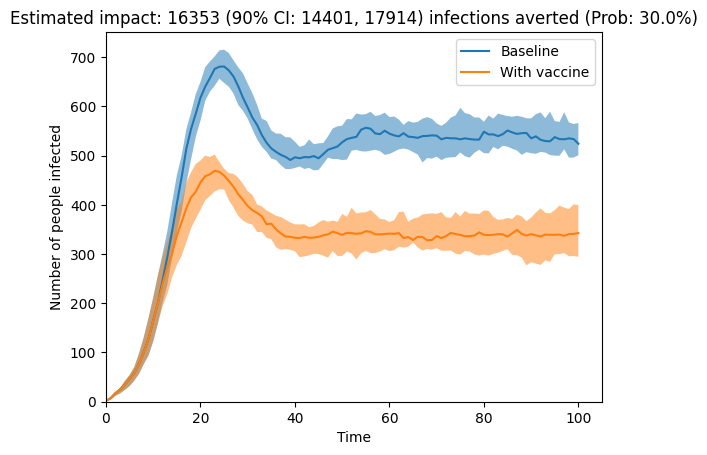

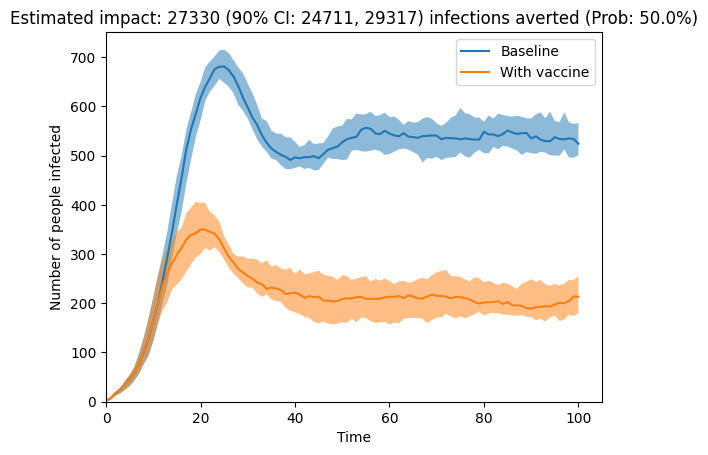

In [ ]:
### Try different vaccination proportions
def vac_prob(probs = [0.3, 0.5]):
    for prob in probs:
        # Prepare to run multiple times
        n_seeds = 20  # Don't use too many here or your sim will take a very long time!
        n_timesteps = 100  # Again, don't use too many
        baseline_results = np.empty((n_seeds, n_timesteps+1))  # Initialize storage of baseline results
        vaccine_results  = np.empty((n_seeds, n_timesteps+1))  # Initialize storage of vaccine results
        difference_results = np.empty(n_seeds)  # Initialize storage of differences - this will tell us the impact
        baseline_sims = [] # Initialize the list of baseline simulations
        vaccine_sims = [] # Initialize the list of baseline simulations
        # Make the simulations with different seeds
        for seed in range(n_seeds): # Run over 5 different random seeds
            baseline_sim = make_sim(seed=seed, n_timesteps=n_timesteps) # Run the simulation with no vaccine
            vaccine_sim  = make_sim(seed=seed, prob=prob, n_timesteps=n_timesteps, use_vaccine=True) # Run the simulation with the vaccine
            baseline_sims.append(baseline_sim) # Add the baseline sim to the list
            vaccine_sims.append(vaccine_sim) # Add the vaccine sim to the list
        
        def run_sim(sim):
            """ Run the simulation and return the results """
            sim.run()
            results = sc.objdict()
            results.time = sim.yearvec
            results.n_infected = sim.results.meningitis.n_infected
            return results
        
        # Run the simulations in parallel
        baseline_sim_results = sc.parallelize(run_sim, baseline_sims) # Run baseline sims
        vaccine_sim_results  = sc.parallelize(run_sim, vaccine_sims) # Run the vaccine sims
        
        
        # Pull out the results
        for seed in range(n_seeds):
            baseline = baseline_sim_results[seed]
            vaccine = vaccine_sim_results[seed]
            baseline_results[seed, :] = baseline.n_infected # Pull out results from baseline
            vaccine_results[seed, :] = vaccine.n_infected  # Pull out results from vaccine scenarios
            difference_results[seed] = baseline_results[seed, :].sum() - vaccine_results[seed, :].sum()  # Calculate differences
        
        # Get the qunatiles for plotting
        lower_bound_baseline = np.quantile(baseline_results, 0.05, axis=0)
        median_baseline      = np.quantile(baseline_results, 0.5, axis=0)
        upper_bound_baseline = np.quantile(baseline_results, 0.95, axis=0)
        lower_bound_vaccine  = np.quantile(vaccine_results, 0.05, axis=0)
        median_vaccine       = np.quantile(vaccine_results, 0.5, axis=0)
        upper_bound_vaccine  = np.quantile(vaccine_results, 0.95, axis=0)
        
        # Get the time vector for plotting
        time = baseline.time
        
        # Calculate differences
        lower_bound_diff = np.quantile(difference_results, 0.05)
        upper_bound_diff = np.quantile(difference_results, 0.95)
        median_diff = np.quantile(difference_results, 0.5)
        xx = prob*100
        title = f'Estimated impact: {median_diff:.0f} (90% CI: {lower_bound_diff:.0f}, {upper_bound_diff:.0f}) infections averted (Prob: {xx}%)'
        
        
        # Do the plotting
        pl.figure()  # Create the figure
        pl.title(title)
        pl.fill_between(time, lower_bound_baseline, upper_bound_baseline, alpha=0.5) # Plot the uncertainty bound for baseline
        pl.plot(time, median_baseline, label='Baseline') # Plot the median for baseline
        pl.fill_between(time, lower_bound_vaccine, upper_bound_vaccine, alpha=0.5) # Plot the uncertainty bound for vaccine
        pl.plot(time, median_vaccine, label='With vaccine') # Plot the median for vaccine
        pl.xlabel('Time')
        pl.ylabel('Number of people infected')
        pl.legend() # Add legend
        pl.ylim(bottom=0) # Star the y-axis at 0
        pl.xlim(left=0) # Start the x-axis at 0
        pl.savefig(f'figs/vaccine_whole_pop{xx}.png')
        pl.show()
vac_prob()

In [ ]:
# Define people with the right age structure
class VaccineAge(ss.Intervention):
    def __init__(self, age_range=None, timestep=10, prob=0.5, imm_boost=2.0):
        super().__init__() # Initialize the intervention
        self.timestep = timestep # Store the timestep the vaccine is applied on
        self.prob = prob # Store the probability of vaccination
        self.imm_boost = imm_boost # Store the amount by which immunity is boosted
        self.age_range = age_range

    def apply(self, sim): # Apply the vaccine
        if sim.ti == self.timestep: # Only apply on the matching timestep
            meningitis = sim.diseases.meningitis # Shorten the name of the disease module
            eligibility_conditions = meningitis.susceptible
            
            if self.age_range is not None: 
                lower_age = self.age_range[0]
                upper_age = self.age_range[1]
                age_conditions = (sim.people.age >= lower_age) & (sim.people.age < upper_age)
                eligibility_conditions = eligibility_conditions & age_conditions
                
            eligible_ids = sim.people.uid[eligibility_conditions] # Only susceptible people are eligible
                
            n_eligible = len(eligible_ids)  # Number of people who are eligible
            to_vaccinate = self.prob > np.random.rand(n_eligible) # Define which of the n_eligible people get vaccinated
            vaccine_ids = eligible_ids[to_vaccinate]
            meningitis.immunity[vaccine_ids] += self.imm_boost

class People(ss.People):
    def update_post(self, sim):
        self.age[self.alive] += 1/365
        return self.age

def make_sim(seed=1, age_range=None, n_timesteps=100, use_vaccine=False, timestep=10, prob=0.5, imm_boost=2.0):
    """ Make the simulation, but do not run it yet """

    pars = dict(
        start = 0,
        end = n_timesteps,
        dt = 1.0,
        verbose = 0,
        rand_seed = seed,
        networks = 'random',
        diseases = dict(
            type = 'meningitis',
            waning = 0.009,
        )
    )

    people = People(n_agents=2000, age_data=age_data)

    # Define "baseline" and "intervention" sims without and with the vaccine
    if use_vaccine:
        vaccine = VaccineAge(timestep=timestep, age_range=age_range, prob=prob, imm_boost=imm_boost)
        sim = ss.Sim(pars, people=people, interventions=vaccine)
    else:
        sim = ss.Sim(pars, people=people)

    return sim

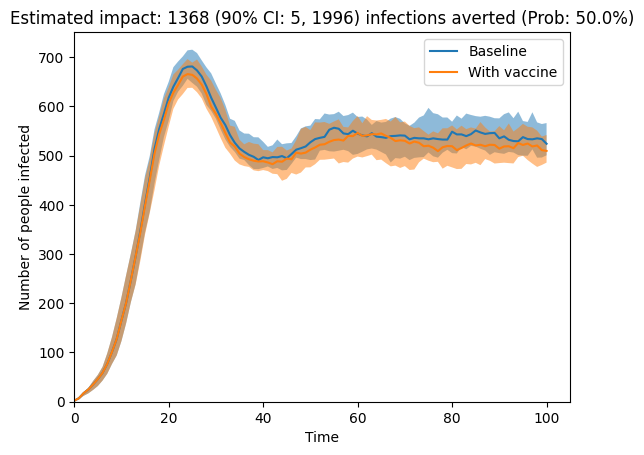

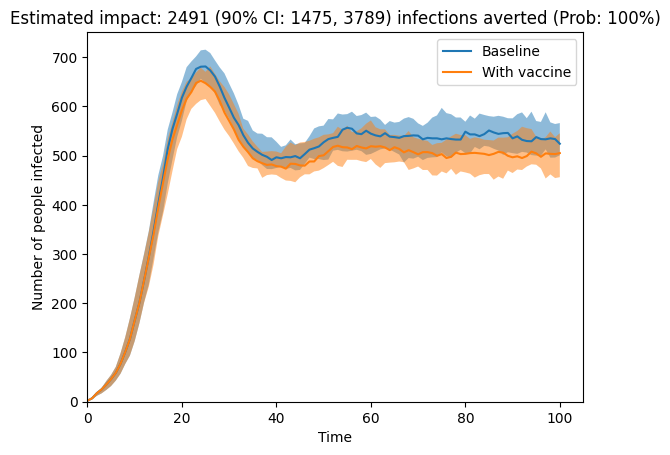

In [ ]:
### Try different vaccination proportions
def vac_prob_age(probs =  [0.5, 1]):
    for prob in probs:
        # Prepare to run multiple times
        n_seeds = 20  # Don't use too many here or your sim will take a very long time!
        n_timesteps = 100  # Again, don't use too many
        age_range = [0.75, 1.5]
        baseline_results = np.empty((n_seeds, n_timesteps+1))  # Initialize storage of baseline results
        vaccine_results  = np.empty((n_seeds, n_timesteps+1))  # Initialize storage of vaccine results
        difference_results = np.empty(n_seeds)  # Initialize storage of differences - this will tell us the impact
        baseline_sims = [] # Initialize the list of baseline simulations
        vaccine_sims = [] # Initialize the list of baseline simulations
        # Make the simulations with different seeds
        for seed in range(n_seeds): # Run over 5 different random seeds
            baseline_sim = make_sim(seed=seed, n_timesteps=n_timesteps) # Run the simulation with no vaccine
            vaccine_sim  = make_sim(seed=seed, age_range=age_range, prob=prob, n_timesteps=n_timesteps, use_vaccine=True) # Run the simulation with the vaccine
            baseline_sims.append(baseline_sim) # Add the baseline sim to the list
            vaccine_sims.append(vaccine_sim) # Add the vaccine sim to the list
        
        def run_sim(sim):
            """ Run the simulation and return the results """
            sim.run()
            results = sc.objdict()
            results.time = sim.yearvec
            results.n_infected = sim.results.meningitis.n_infected
            return results
        
        # Run the simulations in parallel
        baseline_sim_results = sc.parallelize(run_sim, baseline_sims, serial=False) # Run baseline sims
        vaccine_sim_results  = sc.parallelize(run_sim, vaccine_sims, serial=False) # Run the vaccine sims
        
        
        # Pull out the results
        for seed in range(n_seeds):
            baseline = baseline_sim_results[seed]
            vaccine = vaccine_sim_results[seed]
            baseline_results[seed, :] = baseline.n_infected # Pull out results from baseline
            vaccine_results[seed, :] = vaccine.n_infected  # Pull out results from vaccine scenarios
            difference_results[seed] = baseline_results[seed, :].sum() - vaccine_results[seed, :].sum()  # Calculate differences
        
        # Get the qunatiles for plotting
        lower_bound_baseline = np.quantile(baseline_results, 0.05, axis=0)
        median_baseline      = np.quantile(baseline_results, 0.5, axis=0)
        upper_bound_baseline = np.quantile(baseline_results, 0.95, axis=0)
        lower_bound_vaccine  = np.quantile(vaccine_results, 0.05, axis=0)
        median_vaccine       = np.quantile(vaccine_results, 0.5, axis=0)
        upper_bound_vaccine  = np.quantile(vaccine_results, 0.95, axis=0)
        
        # Get the time vector for plotting
        time = baseline.time
        
        # Calculate differences
        lower_bound_diff = np.quantile(difference_results, 0.05)
        upper_bound_diff = np.quantile(difference_results, 0.95)
        median_diff = np.quantile(difference_results, 0.5)
        xx = prob*100
        title = f'Estimated impact: {median_diff:.0f} (90% CI: {lower_bound_diff:.0f}, {upper_bound_diff:.0f}) infections averted (Prob: {xx}%)'
        
        
        # Do the plotting
        pl.figure()  # Create the figure
        pl.title(title)
        pl.fill_between(time, lower_bound_baseline, upper_bound_baseline, alpha=0.5) # Plot the uncertainty bound for baseline
        pl.plot(time, median_baseline, label='Baseline') # Plot the median for baseline
        pl.fill_between(time, lower_bound_vaccine, upper_bound_vaccine, alpha=0.5) # Plot the uncertainty bound for vaccine
        pl.plot(time, median_vaccine, label='With vaccine') # Plot the median for vaccine
        pl.xlabel('Time')
        pl.ylabel('Number of people infected')
        pl.legend() # Add legend
        pl.ylim(bottom=0) # Star the y-axis at 0
        pl.xlim(left=0) # Start the x-axis at 0
        pl.savefig(f'figs/vaccine_9-18_moths{xx}.png')
        pl.show
vac_prob_age()

### Treatment

In [ ]:
class Treatment(ss.Intervention):  # Create a new, generic treatment intervention

    def __init__(self, timestep=10, prob=0.5, mean_dur_infection=5):
        super().__init__() # Initialize the intervention
        self.timestep = timestep # Store the timestep the treatment is applied on
        self.prob = prob # Store the probability of treatment
        self.dur_infection = ss.normal(mean_dur_infection, 1)  # Store the duration of infection

    def apply(self, sim):
        if sim.ti == self.timestep: # Only apply on the matching timestep
            meningitis = sim.diseases.meningitis
            # Define  who is eligible for treatment
            eligible_ids = sim.people.uid[meningitis.ti_infected == sim.ti]  # People are eligible for treatment if they have just started exhibiting symptoms
            n_eligible = len(eligible_ids) # Number of people who are eligible
    
            # Define who receives treatment
            is_treated = np.random.rand(n_eligible) < self.prob  # Define which of the n_eligible people get treated by comparing np.random.rand() to self.p
            treat_ids = eligible_ids[is_treated]  # Pull out the IDs for the people receiving the treatment
    
            # Treated people will have a new disease progression
            dur_inf = self.dur_infection.rvs(treat_ids)  # Sample duration of infection by generating random variables (RVS) drawn from the distribution of durations
    
            # Determine who dies and who recovers and when
            will_die = meningitis.pars.p_death.rvs(treat_ids)  # Sample probability of dying
            dead_uids = treat_ids[will_die]  # Pull out the IDs of people who die
            recover_uids = treat_ids[~will_die]  # Pull out the IDs of people who recovery
            meningitis.ti_dead[dead_uids] = meningitis.ti_infected[dead_uids] + dur_inf[will_die] / sim.dt  # Set the time of death
            meningitis.ti_recovered[recover_uids] = meningitis.ti_infected[recover_uids] + dur_inf[~will_die] / sim.dt  # Set the time of recovery


def make_sim(seed=1, n_timesteps=100, use_treatment=False, timestep=20, prob=0.5, mean_dur_infection=5):
    """ Make the simulation, but do not run it yet """

    pars = dict(
        n_agents = 2000,
        start = 0,
        end = n_timesteps,
        dt = 1.0,
        verbose = 0,
        rand_seed = seed,
        networks = 'random',
        diseases = dict(
            type = 'meningitis',
        )
    )

    # Define "baseline" and "intervention" sims without and with the treatment
    if use_treatment:
        treatment = Treatment(timestep=timestep, prob=prob, mean_dur_infection=mean_dur_infection)
        sim = ss.Sim(pars, interventions=treatment)
    else:
        sim = ss.Sim(pars)

    return sim

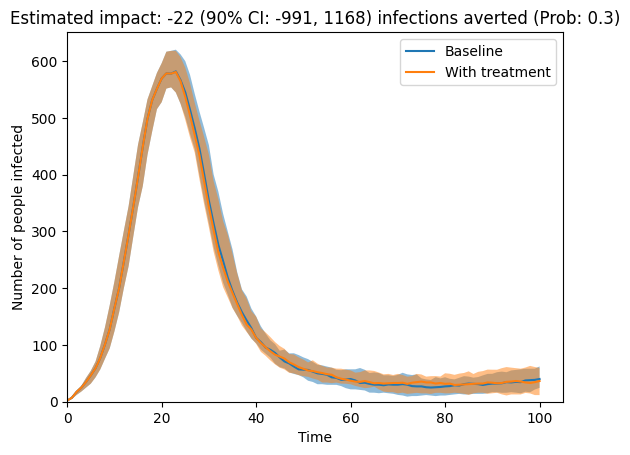

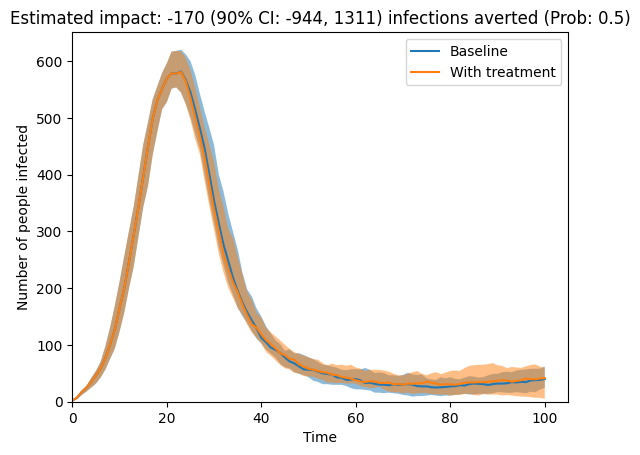

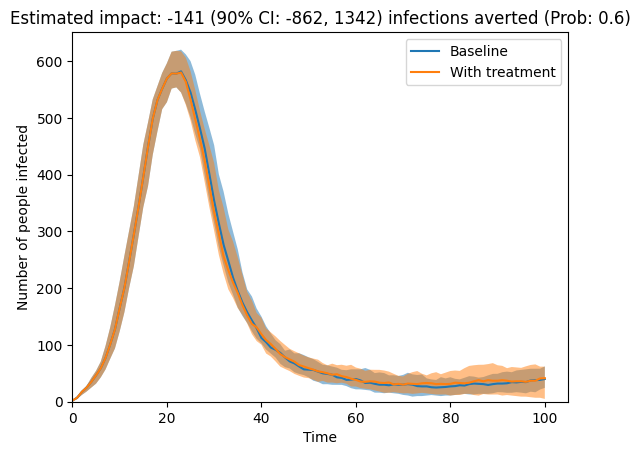

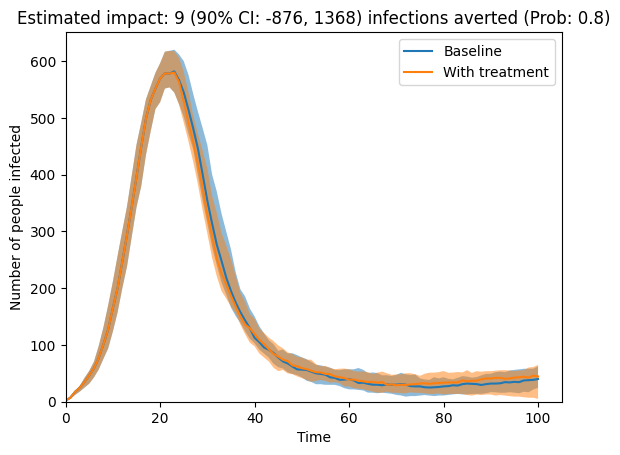

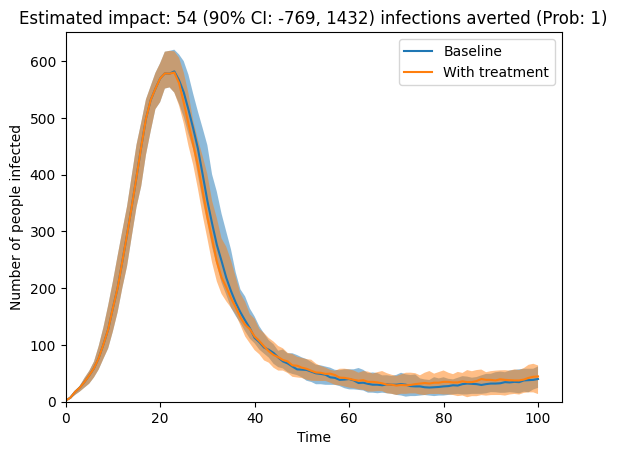

In [ ]:
def treat_prob(probs = [0.3, 0.5, 0.6, 0.8, 1]):
    for prob in probs:
        # Prepare to run multiple times
        n_seeds = 20  # Don't use too many here or your sim will take a very long time!
        n_timesteps = 100  # Again, don't use too many
        baseline_results = np.empty((n_seeds, n_timesteps+1))  # Initialize storage of baseline results
        treatment_results  = np.empty((n_seeds, n_timesteps+1))  # Initialize storage of treatment results
        difference_results = np.empty(n_seeds)  # Initialize storage of differences - this will tell us the impact
        baseline_sims = [] # Initialize the list of baseline simulations
        treatment_sims = [] # Initialize the list of baseline simulations
        
        # Make the simulations with different seeds
        for seed in range(n_seeds): # Run over 5 different random seeds
            baseline_sim = make_sim(seed=seed, n_timesteps=n_timesteps) # Run the simulation with no treatment
            treatment_sim  = make_sim(seed=seed, prob=prob, n_timesteps=n_timesteps, use_treatment=True) # Run the simulation with the treatment
            baseline_sims.append(baseline_sim) # Add the baseline sim to the list
            treatment_sims.append(treatment_sim) # Add the treatment sim to the list
        
        def run_sim(sim):
            """ Run the simulation and return the results """
            sim.run()
            results = sc.objdict()
            results.time = sim.yearvec
            results.n_infected = sim.results.meningitis.n_infected
            return results
        
        # Run the simulations in parallel
        baseline_sim_results = sc.parallelize(run_sim, baseline_sims) # Run baseline sims
        treatment_sim_results  = sc.parallelize(run_sim, treatment_sims) # Run the treatment sims
        
        
        # Pull out the results
        for seed in range(n_seeds):
            baseline = baseline_sim_results[seed]
            treatment = treatment_sim_results[seed]
            baseline_results[seed, :] = baseline.n_infected # Pull out results from baseline
            treatment_results[seed, :] = treatment.n_infected  # Pull out results from treatment scenarios
            difference_results[seed] = baseline_results[seed, :].sum() - treatment_results[seed, :].sum()  # Calculate differences
        
        # Get the qunatiles for plotting
        lower_bound_baseline = np.quantile(baseline_results, 0.05, axis=0)
        median_baseline      = np.quantile(baseline_results, 0.5, axis=0)
        upper_bound_baseline = np.quantile(baseline_results, 0.95, axis=0)
        lower_bound_treatment  = np.quantile(treatment_results, 0.05, axis=0)
        median_treatment       = np.quantile(treatment_results, 0.5, axis=0)
        upper_bound_treatment  = np.quantile(treatment_results, 0.95, axis=0)
        
        # Get the time vector for plotting
        time = baseline.time
        
        # Calculate differences
        lower_bound_diff = np.quantile(difference_results, 0.05)
        upper_bound_diff = np.quantile(difference_results, 0.95)
        median_diff = np.quantile(difference_results, 0.5)
        title = f'Estimated impact: {median_diff:.0f} (90% CI: {lower_bound_diff:.0f}, {upper_bound_diff:.0f}) infections averted (Prob: {prob})'
        
        
        # Do the plotting
        pl.figure()  # Create the figure
        pl.title(title)
        pl.fill_between(time, lower_bound_baseline, upper_bound_baseline, alpha=0.5) # Plot the uncertainty bound for baseline
        pl.plot(time, median_baseline, label='Baseline') # Plot the median for baseline
        pl.fill_between(time, lower_bound_treatment, upper_bound_treatment, alpha=0.5) # Plot the uncertainty bound for treatment
        pl.plot(time, median_treatment, label='With treatment') # Plot the median for treatment
        pl.xlabel('Time')
        pl.ylabel('Number of people infected')
        pl.legend() # Add legend
        pl.ylim(bottom=0) # Star the y-axis at 0
        pl.xlim(left=0) # Start the x-axis at 0
        pl.show()
treat_prob()

## More plots

In [ ]:
import pylab as pl
def plot_more(sim, var, add = False, nrow=2, ncol=2, figsize=(8, 8)):
    if (ncol*nrow)>len(var):
        ncol = 1
        nrow = len(var)
    fig, axs = pl.subplots(nrow, ncol, figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        x = sim.tivec
        if add:
            y =  sim.results.meningitis[var[i]]
        else:
            y = sim.results[var[i]]
        ax.plot(x, y)
        ax.set_title(var[i])
    pl.tight_layout()
    return fig

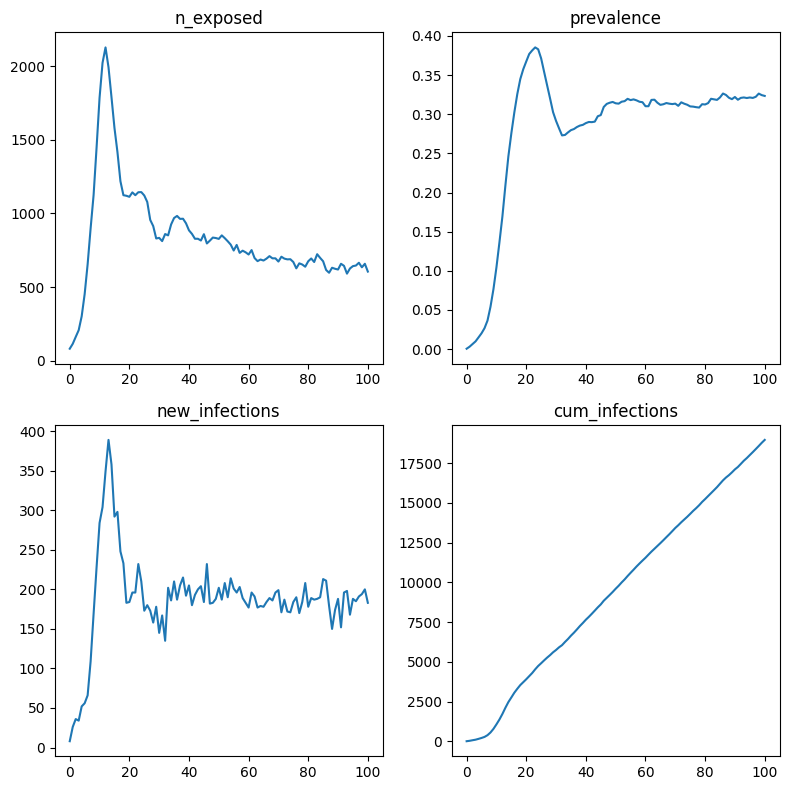

In [ ]:
vars = ['n_exposed',
 'prevalence',
 'new_infections',
 'cum_infections']
p0 = plot_more(sim, vars, add=True)
p0.savefig('figs/dynamic_summary.png')

In [ ]:
sim.results

#0. 'n_alive':
Result(sim.n_alive):
array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000.,  9995.,  9995.,  9977.,  9974.,
         9954.,  9953.,  9947.,  9945.,  9939.,  9930.,  9919.,  9911.,
         9900.,  9883.,  9867.,  9848.,  9834.,  9812.,  9797.,  9781.,
         9769.,  9756.,  9743.,  9731.,  9725.,  9714.,  9704.,  9693.,
         9684.,  9681.,  9671.,  9663.,  9654.,  9647.,  9637.,  9628.,
         9614.,  9603.,  9595.,  9580.,  9565.,  9556.,  9552.,  9544.,
         9529.,  9519.,  9510.,  9496.,  9488.,  9478.,  9474.,  9462.,
         9449.,  9438.,  9424.,  9407.,  9393.,  9383.,  9375.,  9360.,
         9357.,  9349.,  9338.,  9331.,  9320.,  9312.,  9304.,  9295.,
         9283.,  9270.,  9259.,  9252.,  9244.,  9231.,  9222.,  9215.,
         9206.,  9198.,  9193.,  9182.,  9173.,  9164.,  9153.,  9143.,
         9131.,  9121.,  9111.,  9104.,  9093.])
————————————————————————————————————————
#1. 'new_de